In [13]:
import os
import pandas as pd
seeds = [1, 2, 3, 4, 5]
num_tasks = 3
def make_metrics_fine(base_path):    
    accs_per_seed = []
    overall_accs_per_seed = []

    # --- 各シードの2回目 inferenceだけを抽出 ---
    for seed in seeds:
        file_path = os.path.join(base_path, f"seed{seed}.csv")
        if not os.path.exists(file_path):
            print(f"警告: ファイルが存在しません: {file_path}")
            continue
        df = pd.read_csv(file_path)


        # 各タスクの 2 回目の inference
        inf2_index = df.groupby('task').nth(1).index if not df.empty else []
        df_filtered = df.drop(index=inf2_index)

        # --- 逆三角形 acc_matrix 用にテスト精度を抽出 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        accs_per_seed.append(acc_list)

    # --- overall_acc 用に 2回目 inference のみ抽出 ---
        if len(inf2_index) > 0:
            overall_accs_per_seed.append(df.loc[inf2_index, 'テスト精度 (Test Acc)'].tolist())
        else:
            overall_accs_per_seed.append([])

    # --- シード平均 ---
    max_len = max(len(lst) for lst in accs_per_seed)
    accs_avg = []
    for i in range(max_len):
        vals = [lst[i] for lst in accs_per_seed if i < len(lst)]
        accs_avg.append(sum(vals)/len(vals))
    
    # --- 逆三角形の acc_matrix 作成 ---
    acc_matrix = []
    current_pos = 0
    for k in range(num_tasks):
        row_len = k+1  # 下三角分だけ
        row=accs_avg[current_pos: current_pos + row_len]
        acc_matrix.append(row[::-1]) 
        current_pos += row_len
    
    # --- overall_acc をシード平均で計算 ---
    overall_acc_avg = []
    # overall_accs_per_seed はリストのリスト [[seed1のinf2],[seed2のinf2],...]
    # transposeしてタスクごとに平均
    if overall_accs_per_seed and any(overall_accs_per_seed):
        max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
        for i in range(max_len_overall):
            vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
            overall_acc_avg.append(sum(vals)/len(vals))
    else:
        overall_acc_avg = [np.nan]*num_tasks

    return acc_matrix, overall_acc_avg

make_metrics_fine("/work/csv/uci-har/cil_each/ncp")

([[0.9267499923706055],
  [0.199399995803833, 0.9667499899864197],
  [0.0, 0.0, 0.7965999960899353]],
 [0.7394999980926513, 0.472222226858139, 0.3662857174873352])

In [14]:
def make_metrics_ewc(base_dir):
    acc_matrices_per_seed = []
    overall_accs_per_seed = []
    for seed in seeds:
        file_path = os.path.join(base_dir, f"seed{seed}.csv")

        df = pd.read_csv(file_path)

        # --- 2回目 inference の抽出 ---
        inf2_df = df.groupby('task').nth(1)  # 各タスク2行目
        overall_accs = inf2_df['テスト精度 (Test Acc)'].tolist()
        overall_accs_per_seed.append(overall_accs)
        df_filtered = df.drop(index=inf2_df.index)

        # --- acc_matrix 構築 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        acc_matrix = []
        idx = 0
        for k in range(num_tasks):
            row = acc_list[idx: idx + k + 1]
            acc_matrix.append(row)
            idx += k + 1
        acc_matrices_per_seed.append(acc_matrix)


    # --- seed 平均 ---
    # acc_matrix 平均を作成
    max_len = max(len(m) for m in acc_matrices_per_seed)
    acc_matrix_avg = []
    for k in range(num_tasks):
        rows = []
        for m in acc_matrices_per_seed:
            if k < len(m):
                rows.append(m[k])
        if rows:
            row_len = max(len(r) for r in rows)
            row_avg = []
            for j in range(row_len):
                vals = [r[j] for r in rows if j < len(r)]
                row_avg.append(sum(vals)/len(vals) if vals else np.nan)
            acc_matrix_avg.append(row_avg)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)
    
    return acc_matrix_avg, overall_acc_avg
make_metrics_ewc("/work/csv/uci-har/cil_each/ewc/lambda50000")

([[0.9267499923706055],
  [0.0, 0.971749997138977],
  [0.01199999973177908, 0.11200000122189517, 0.9807999968528748]],
 [0.9267499923706055, 0.4752222239971161, 0.3854285717010498])

In [15]:
def make_metrics_er(base_dir,mem,bs):
    acc_matrices_per_seed = []
    overall_accs_per_seed = []
    for seed in seeds:
        file_path = os.path.join(base_dir, f"seed{seed}",  f"mem{mem}", f"bs{bs}.csv")

        df = pd.read_csv(file_path)

        # --- 2回目 inference の抽出 ---
        inf2_df = df.groupby('task').nth(1)  # 各タスク2行目
        overall_accs = inf2_df['テスト精度 (Test Acc)'].tolist()
        overall_accs_per_seed.append(overall_accs)
        df_filtered = df.drop(index=inf2_df.index)

        # --- acc_matrix 構築 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        acc_matrix = []
        idx = 0
        for k in range(num_tasks):
            row = acc_list[idx: idx + k + 1]
            acc_matrix.append(row)
            idx += k + 1
        acc_matrices_per_seed.append(acc_matrix)


    # --- seed 平均 ---
    # acc_matrix 平均を作成
    max_len = max(len(m) for m in acc_matrices_per_seed)
    acc_matrix_avg = []
    for k in range(num_tasks):
        rows = []
        for m in acc_matrices_per_seed:
            if k < len(m):
                rows.append(m[k])
        if rows:
            row_len = max(len(r) for r in rows)
            row_avg = []
            for j in range(row_len):
                vals = [r[j] for r in rows if j < len(r)]
                row_avg.append(sum(vals)/len(vals) if vals else np.nan)
            acc_matrix_avg.append(row_avg)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)
    
    return acc_matrix_avg, overall_acc_avg
make_metrics_er("/work/csv/uci-har/cil_each/er", 5000, 10)

([[0.9267499923706055],
  [0.8952499985694885, 0.9177500009536743],
  [0.93125, 0.9174999952316284, 0.9866000056266785]],
 [0.9267499923706055, 0.7922222137451171, 0.6891428589820862])

In [16]:
seeds = [1, 2, 3, 4, 5]
num_tasks = 3

def make_metrics_pnn(base_dir):
    acc_metrics_per_seed = []      # seedごとの結果をためる
    overall_accs_per_seed = []     # overall acc を seed ごとに保存

    for seed in seeds:
        csv_path = os.path.join(base_dir, f"seed{seed}.csv")
        if not os.path.exists(csv_path):
            print(f"警告: CSVが存在しません: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        # --- 2回目 inference を overall として抽出 ---
        overall_accs = df[df["phase_type"]=="inference"]["テスト精度 (Test Acc)"].tolist()
        overall_accs_per_seed.append(overall_accs)

        # --- 1回目 inference（acc_list） ---
        acc_list = df[df["phase_type"]=="training"]["テスト精度 (Test Acc)"].tolist()
        print(f"Seed {seed} Acc List: {acc_list}")
        if len(acc_list) != num_tasks:
            print(f"警告: Task数と一致しません Seed {seed}")

        # --- 指標計算 ---
        df_seed = pd.DataFrame({
            "Task": list(range(1, num_tasks+1)),
            "Acc": acc_list,
            "Overall Acc": overall_accs[:num_tasks]  # safety
        })
        df_seed["Seed"] = seed
        acc_metrics_per_seed.append(df_seed)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)

    # --- 逆三角形 acc_matrix 作成（対角のみ保持） ---
    acc_matrix = []
    for k in range(num_tasks):
        row = [0] * num_tasks
        vals = [df_seed.iloc[k]["Acc"] for df_seed in acc_metrics_per_seed if k < len(df_seed)]
        row[k] = sum(vals)/len(vals) if vals else np.nan
        acc_matrix.append(row)

    return acc_matrix, overall_acc_avg

make_metrics_pnn("/work/csv/uci-har/cil_each/pnn")

Seed 1 Acc List: [0.9362499713897704, 0.9662500023841858, 1.0]
Seed 2 Acc List: [0.8987500071525574, 0.96875, 0.9990000128746032]
Seed 3 Acc List: [0.928749978542328, 0.96875, 0.9739999771118164]
Seed 4 Acc List: [0.8987500071525574, 0.9674999713897704, 0.9869999885559082]
Seed 5 Acc List: [0.9712499976158142, 0.9674999713897704, 1.0]


([[0.9267499923706055, 0, 0],
  [0, 0.9677499890327453, 0],
  [0, 0, 0.9919999957084655]],
 [0.9267499923706055, 0.4706666707992554, 0.35742856860160827])

In [17]:
def make_joint_metrics(base_dir):
    joint_accs_per_seed = []
    for seed in seeds:
        joint_file_path = os.path.join(base_dir, f"seed{seed}.csv")
        df_joint = pd.read_csv(joint_file_path)
         # --- joint acc ---
        joint_accs = df_joint['テスト精度 (Test Acc)'].head(num_tasks).tolist()
        joint_accs_per_seed.append(joint_accs)

     # joint 平均
    joint_accs_avg = []
    for t in range(num_tasks):
        vals = [lst[t] for lst in joint_accs_per_seed if t < len(lst)]
        joint_accs_avg.append(sum(vals)/len(vals) if vals else np.nan)

    return joint_accs_avg
make_joint_metrics("/work/csv/uci-har/cil_each/ncp/joint")

[0.9267499923706055, 0.9502222299575805, 0.9070000171661377]

Seed 1 Acc List: [0.9362499713897704, 0.9662500023841858, 1.0]
Seed 2 Acc List: [0.8987500071525574, 0.96875, 0.9990000128746032]
Seed 3 Acc List: [0.928749978542328, 0.96875, 0.9739999771118164]
Seed 4 Acc List: [0.8987500071525574, 0.9674999713897704, 0.9869999885559082]
Seed 5 Acc List: [0.9712499976158142, 0.9674999713897704, 1.0]


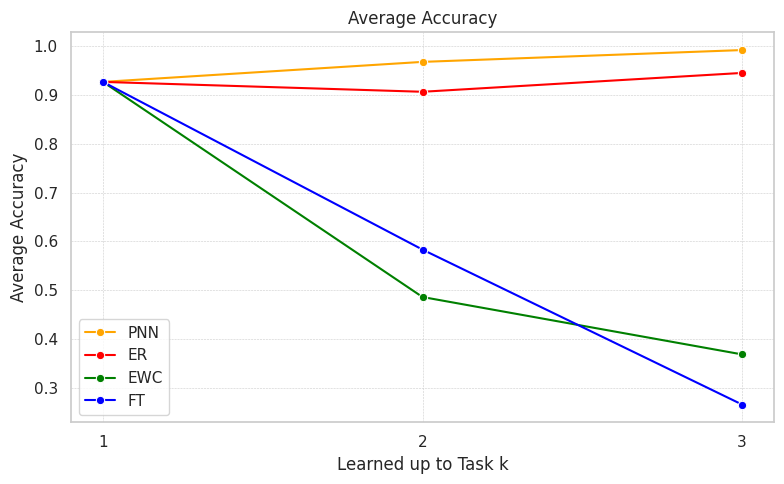

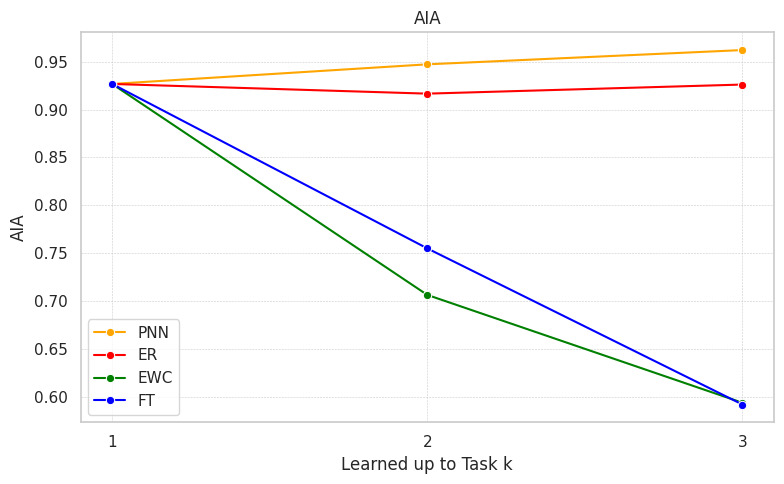

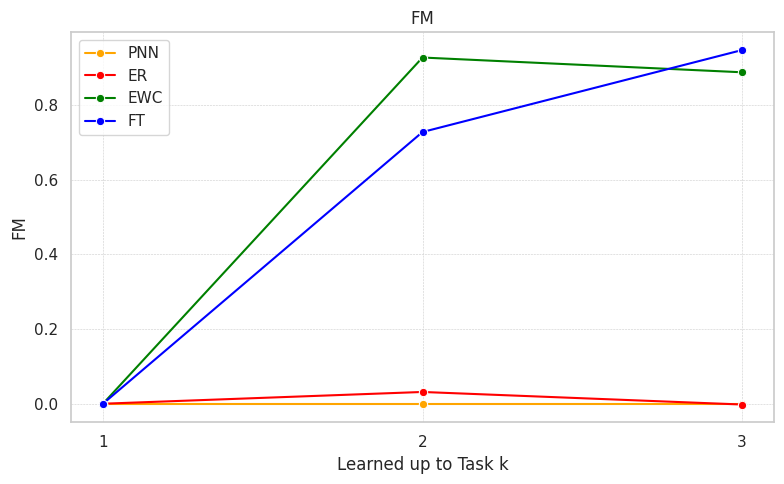

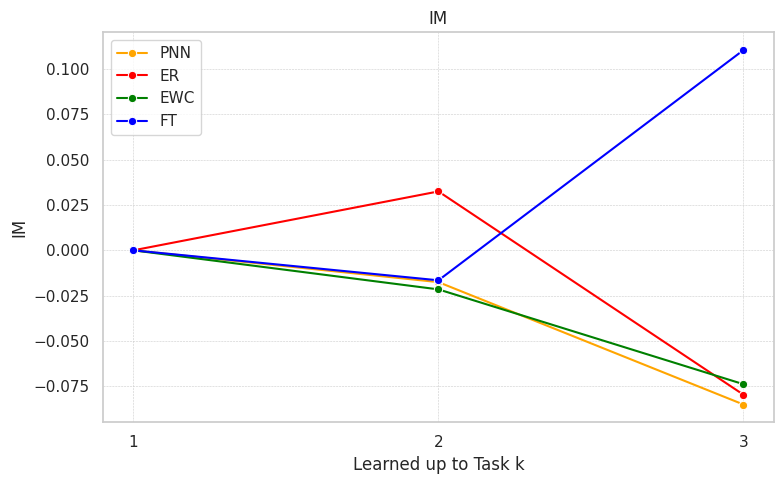

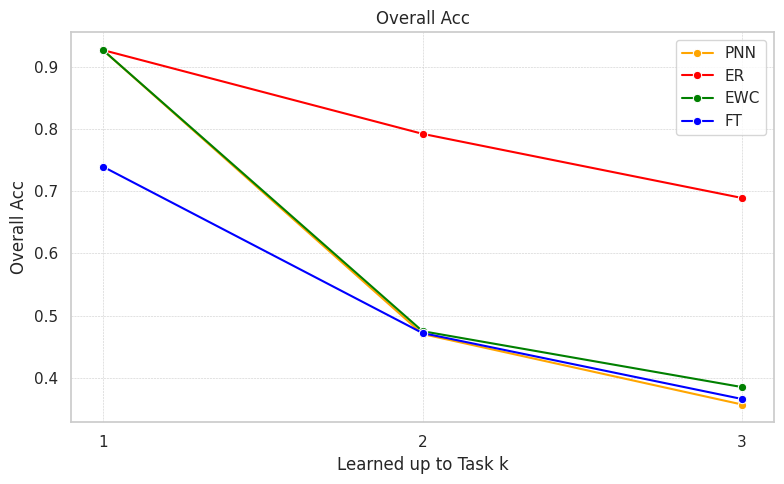

In [26]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CSVディレクトリパス ---
csv_dirs = {
    "PNN": "/work/csv/uci-har/cil_each/pnn",
    "ER": "/work/csv/uci-har/cil_each/er",
    "EWC": "/work/csv/uci-har/cil_each/ewc/lambda50000",
    "FT": "/work/csv/uci-har/cil_each/ncp",
}
joint_csv = "/work/csv/uci-har/cil_each/ncp/joint"

# --- 指標計算関数 ---
def compute_metrics(acc_matrix, joint_acc=None, overall_acc_avg=None):
    num_tasks = len(acc_matrix)
    AA_list, AIA_list, fm_list, im_list = [], [], [], []

    for k in range(num_tasks):
        current_accs = acc_matrix[k][:k+1]
        AA_list.append(float(np.mean(current_accs)) if current_accs else 0.0)
        AIA_list.append(float(np.mean(AA_list)))

    fm_list.append(0.0)
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs = [acc_matrix[l][j] for l in range(j, k) if l < len(acc_matrix) and j < len(acc_matrix[l])]
            max_past_acc = max(past_accs) if past_accs else 0.0
            current_acc = acc_matrix[k][j] if k < len(acc_matrix) and j < len(acc_matrix[k]) else 0.0
            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum / k)

    for k in range(num_tasks):
        if joint_acc is not None and k < len(joint_acc):
            cl_acc_k = acc_matrix[k][k] if k < len(acc_matrix[k]) else np.nan
            im_list.append(joint_acc[k] - cl_acc_k)
        else:
            im_list.append(np.nan)

    results = []
    for k in range(num_tasks):
        results.append({
            'Task': k+1,
            'Average Accuracy': AA_list[k],
            'AIA': AIA_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Overall Acc': overall_acc_avg[k]
        })
    return pd.DataFrame(results)


def compute_metrics_pnn(acc_matrix, joint_acc=None, overall_acc=None):
    num_tasks = len(acc_matrix)
    AA_list, AIA_list, fm_list, im_list = [], [], [], []

    for k in range(num_tasks):
        current_accs = acc_matrix[k][k]
        AA_list.append(float(np.mean(current_accs)) if current_accs else 0.0)
        AIA_list.append(float(np.mean(AA_list)))

    fm_list=[0.0]*num_tasks

    for k in range(num_tasks):
        if joint_acc is not None and k < len(joint_acc):
            cl_acc_k = acc_matrix[k][k] if k < len(acc_matrix[k]) else np.nan
            im_list.append(joint_acc[k] - cl_acc_k)
        else:
            im_list.append(np.nan)

    results = []
    for k in range(num_tasks):
        results.append({
            'Task': k+1,
            'Average Accuracy': AA_list[k],
            'AIA': AIA_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Overall Acc': overall_acc_avg[k]
        })
    return pd.DataFrame(results)

seeds = [1, 2, 3, 4, 5]
num_tasks = 3
all_metrics = {}
# --- ディレクトリ内の全seedを読み込み & 平均化 ---
for method, dir_path in csv_dirs.items():
    if method == "PNN":
        make_metrics_func = make_metrics_pnn
    elif method == "EWC":
        make_metrics_func = make_metrics_ewc
    elif method == "ER":
        make_metrics_func = lambda p: make_metrics_er(p, 5000, 10)
    elif method == "FT":
        make_metrics_func = make_metrics_fine
    acc_matrix, overall_acc_avg = make_metrics_func(dir_path)
    joint_acc_avg = make_joint_metrics(joint_csv) if os.path.exists(joint_csv) else None
    if method == "PNN":
        df_metrics = compute_metrics_pnn(acc_matrix, joint_acc_avg, overall_acc_avg)
    else:
        df_metrics = compute_metrics(acc_matrix, joint_acc_avg, overall_acc_avg)
    all_metrics[method] = df_metrics

# --- 可視化 ---
sns.set(style="whitegrid")
metrics_to_plot = ["Average Accuracy", "AIA", "FM", "IM", "Overall Acc"]

color_palette = {
    "PNN": "orange",
    "EWC": "green",
    "ER": "red",
    "FT": "blue"
}

for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    for method, df_metric in all_metrics.items():
        sns.lineplot(
            data=df_metric,
            x="Task",
            y=metric,
            marker="o",
            label=method,
            color=color_palette[method]  # ←ここで直接指定
        )
    plt.title(f"{metric}")
    plt.xlabel("Learned up to Task k")
    plt.xticks(range(1, num_tasks+1))
    plt.grid(True, linestyle="--", linewidth=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
